In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [11]:
def get_clear_data(df):
    # Drop the date column from the dataframe
    if 'data' in df.columns:
        df.drop(columns=['date'], inplace=True)
    if 'model' in df.columns:
        df.drop(columns=['model'], inplace=True)
    if 'serial_number' in df.columns:
        df.drop(columns=['serial_number'], inplace=True)

    df_filled = df.fillna(df.mean())

    # Keep the original 'failure' column unchanged
    df_filled['failure'] = df['failure']

    return df_filled

In [12]:
# Load the entire dataset into a pandas dataframe
column_list = []
column_list.append('date')
column_list.append('failure')
column_list.append('model')
column_list.append('serial_number')
column_list.append('smart_5_raw')
column_list.append('smart_9_raw')
column_list.append('smart_184_raw')
column_list.append('smart_187_raw')
column_list.append('smart_193_raw')
column_list.append('smart_197_raw')
column_list.append('smart_198_raw')
column_list.append('smart_240_raw')
column_list.append('smart_241_raw')
column_list.append('smart_242_raw')

df = pd.read_parquet('/nobackup/amimalik/bits/dataset/dimensions/4Q/failed_devices_df_all.parquet', columns=column_list)
model_df = pd.read_csv('/nobackup/amimalik/bits/dataset/dimensions/4Q/sorted_failures.csv')

model_df = model_df.head(5)

In [13]:
def get_df_with_iteration_count(df, count):
    serial_number_counts = df['serial_number'].value_counts()

    # Filter the serial numbers based on value counts
    filtered_serial_numbers = serial_number_counts[serial_number_counts > count].index

    # Create a new dataframe with filtered serial numbers
    filtered_df = df[df['serial_number'].isin(filtered_serial_numbers)].copy()

    # reset index inplace 
    filtered_df.reset_index(drop=True, inplace=True)

    # copy the dataframe to ddf
    filtered_df = filtered_df.copy()

    return filtered_df

In [14]:
def get_resample_data(df, sample_frequency):
    # Group the dataframe by serial number
    grouped_df = df.groupby('serial_number')

    # Create an empty list to store the resampled dataframes
    resampled_dfs = []

    # Iterate over each group
    for name, group in grouped_df:
        # Resample the group to weekly frequency
        resampled_group = group.resample(sample_frequency, on='date').max()
        # drop the tail row if the last row is not a failure
        while resampled_group.tail(1)['failure'].values[0] != 1:
            resampled_group = resampled_group[:-1]
        # Append the resampled group to the list
        resampled_dfs.append(resampled_group)

    # Concatenate the list of dataframes into a single dataframe
    resampled_data = pd.concat(resampled_dfs)

    # Reset the index of the dataframe
    # resampled_data.reset_index(drop=True, inplace=True)

    return resampled_data

In [15]:
def get_norm(ddf):
    raw_columns = [col for col in ddf.columns if 'raw' in col]

    scaler = MinMaxScaler()
    scaler.fit(ddf[raw_columns])
    normalized_data = scaler.transform(ddf[raw_columns])
    normalized_data = pd.DataFrame(normalized_data, columns=raw_columns)

    # Drop the raw columns from the original dataframe and combine the normalized data with the original dataframe
    combined_df = pd.concat([normalized_data, ddf.drop(columns=raw_columns)], axis=1)

    # rename the columns with raw to normalized
    combined_df.columns = combined_df.columns.str.replace('_raw', '_norm')


    combined_df.head()

    combined_df.rename(columns={'failure':'failure', 'smart_5_norm':'Reallocated_Sectors_Count', 'smart_9_norm':'Power-On_Hours',
                        'smart_184_norm':'I/O_Error_Detection_and_Correction','smart_187_norm':'Reported_Uncorrectable_Errors', 
                        'smart_193_norm':'Load_Unload_Cycle', 'smart_197_norm':'Current_Pending_Sector_Count', 'smart_198_norm':'Offline_Uncorrectable',
                        'smart_240_norm':'Head_Flying_Hours', 'smart_241_norm':'Total_LBAs_Written', 'smart_242_norm':'Total_LBAs_Read'}, inplace=True)

    ddf = combined_df.copy()
    return ddf

In [16]:
def split_dataset(df):
    # Split the dataset into features (X) and target variable (y)
    X = df.drop(columns=['failure'])
    y = df['failure']

    # Split the dataset into train and test sets
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

    # Print the shape of the train and test sets
    # print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)

    train_y = np.array(train_y).reshape(-1, 1)
    test_y = np.array(test_y).reshape(-1, 1)

    # train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
    train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
    test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

    # Print the shape of reshaped train and test sets
    # print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)

    return train_X, train_y, test_X, test_y 

In [17]:
def model_fit(X_train, y_train, x_test, y_test, dev_model, epochs=50, batch_size=32, learning_rate=0.001):
    validation_number = int(0.9 * X_train.shape[0])
    validation_X = X_train[validation_number:]
    validation_y = y_train[validation_number:]
    train_X = X_train[:validation_number]
    train_y = y_train[:validation_number]


    # Define the model
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True, dropout=0.25))
    model.add(LSTM(100, return_sequences=True, dropout=0.25))
    model.add(LSTM(50, return_sequences=False, dropout=0.25))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy']) 

    # Fit the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(validation_X, validation_y), verbose=0)

    # summarize performance of the model
    scores = model.evaluate(train_X, train_y, verbose=0)

    # Use the trained model to predict on the test_X dataset
    predictions = model.predict(test_X)


    # Convert the predictions to binary values (0 or 1)
    binary_predictions = (predictions > 0.5).astype(int)


    # Calculate the evaluation metrics
    accuracy = accuracy_score(test_y, binary_predictions)
    precision = precision_score(test_y, binary_predictions)
    recall = recall_score(test_y, binary_predictions)
    f1 = f1_score(test_y, binary_predictions)
    roc_auc = roc_auc_score(test_y, binary_predictions)

    # Print the evaluation metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    print("ROC AUC score:", roc_auc)


    # plot history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title('model accuracy for model: ' + dev_model)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.grid()
    plt.show()

    return model, binary_predictions, scores

/ws/amimalik-bgl/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Accuracy: 0.9772727272727273
Precision: 0.0
Recall: 0.0
F1-score: 0.0
ROC AUC score: 0.5


/ws/amimalik-bgl/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


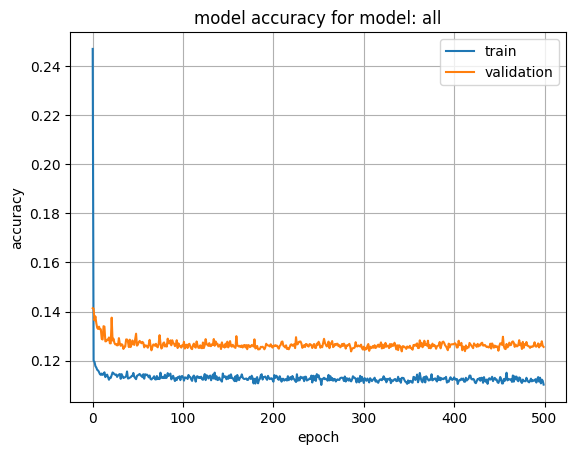

In [18]:
# Filter the dataframe to include only serial numbers with more than count records
ddf = get_df_with_iteration_count(df, 340)
ddf_norm = get_norm(ddf)

# Resample the dataframe to weekly frequency
weekly_df = get_resample_data(ddf_norm, 'W')

# Drop nan values from the dataframe
weekly_df = weekly_df.dropna(how='all')

# Get the clear data
weekly_df = get_clear_data(weekly_df)

# Convert the failure column to integer type
weekly_df['failure'] = weekly_df['failure'].astype(int)


train_X, train_y, test_X, test_y = split_dataset(weekly_df)

model_x, predict_y, score =  model_fit(train_X, train_y, test_X, test_y, epochs=500, batch_size=32, learning_rate=0.001, dev_model="all")


/ws/amimalik-bgl/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Accuracy: 0.9578804347826086
Precision: 0.0
Recall: 0.0
F1-score: 0.0
ROC AUC score: 0.4992917847025496


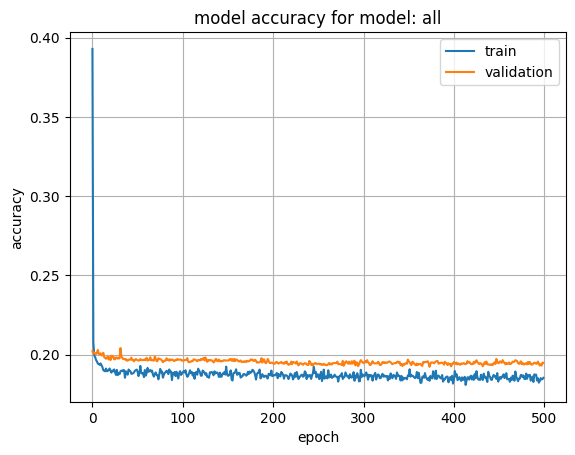

In [19]:
# Filter the dataframe to include only serial numbers with more than count records
ddf = get_df_with_iteration_count(df, 340)
ddf_norm = get_norm(ddf)

# Resample the dataframe to weekly frequency
weekly_df = get_resample_data(ddf_norm, '2W')

# Drop nan values from the dataframe
weekly_df = weekly_df.dropna(how='all')

# Get the clear data
weekly_df = get_clear_data(weekly_df)

# Convert the failure column to integer type
weekly_df['failure'] = weekly_df['failure'].astype(int)


train_X, train_y, test_X, test_y = split_dataset(weekly_df)

model_x, predict_y, score =  model_fit(train_X, train_y, test_X, test_y, epochs=500, batch_size=32, learning_rate=0.001, dev_model="all")

/ws/amimalik-bgl/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Accuracy: 0.8984771573604061
Precision: 0.0
Recall: 0.0
F1-score: 0.0
ROC AUC score: 0.5


/ws/amimalik-bgl/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


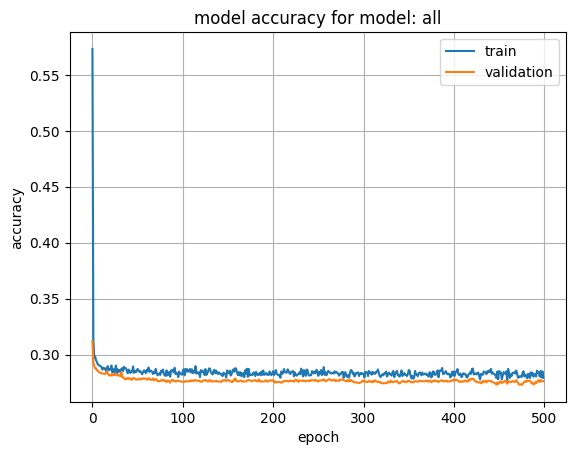

In [20]:
# Filter the dataframe to include only serial numbers with more than count records
ddf = get_df_with_iteration_count(df, 340)
ddf_norm = get_norm(ddf)

# Resample the dataframe to weekly frequency
weekly_df = get_resample_data(ddf_norm, '4W')

# Drop nan values from the dataframe
weekly_df = weekly_df.dropna(how='all')

# Get the clear data
weekly_df = get_clear_data(weekly_df)

# Convert the failure column to integer type
weekly_df['failure'] = weekly_df['failure'].astype(int)


train_X, train_y, test_X, test_y = split_dataset(weekly_df)

model_x, predict_y, score =  model_fit(train_X, train_y, test_X, test_y, epochs=500, batch_size=32, learning_rate=0.001, dev_model="all")

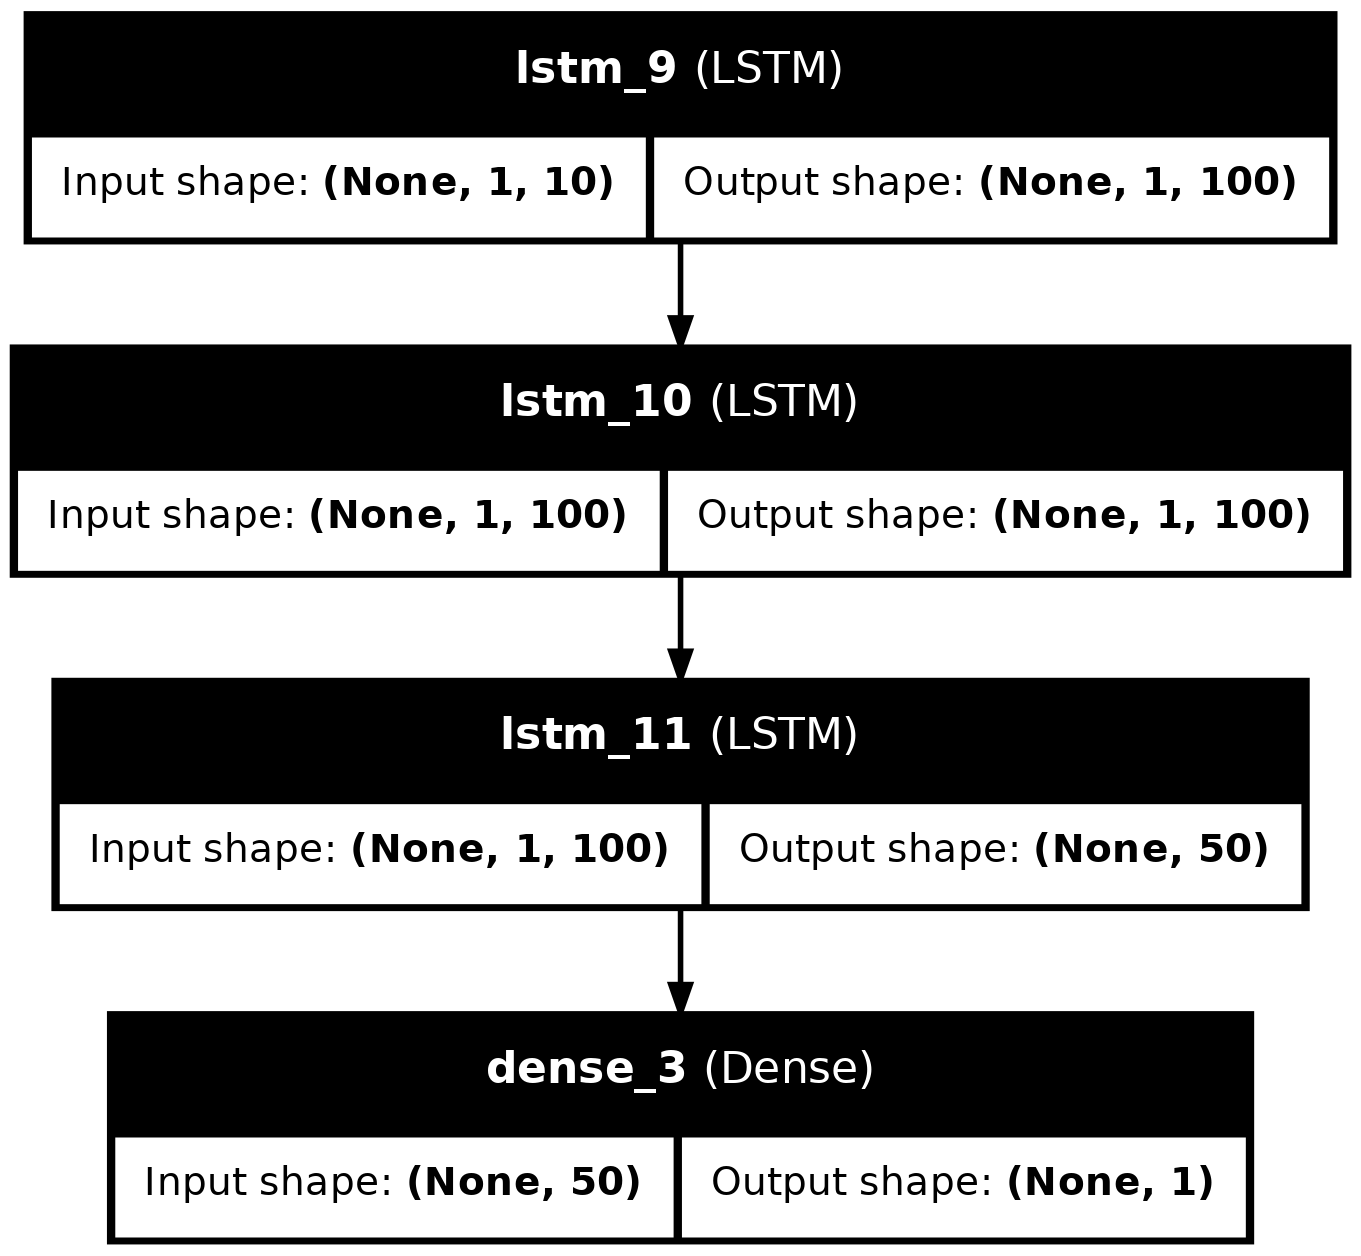

In [21]:
plot_model(model_x, show_shapes=True, show_layer_names=True)